<a href="https://colab.research.google.com/github/chho-work/AOI/blob/master/Synthetic_Antibiogram_Images_PIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction
This notebook go through the steps to create synthetic images.  It shows how to paste a foreground image on top of a background image and find foreground image bounding box.

I used GIMP to create background and foreground images.  I did not show these steps in this notebook.  For more information on how to manipulate images using GIMP, please see the references at the end of the notebook.

Steps:
1. 

### Setup
* Clone the repo: "https://github.com/chho-work/BIODL.git"


In [ ]:
!git clone https://github.com/chho-work/BIODL.git

Cloning into 'BIODL'...
remote: Enumerating objects: 230, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 230 (delta 67), reused 201 (delta 45), pack-reused 0
Receiving objects: 100% (230/230), 1.50 MiB | 8.52 MiB/s, done.
Resolving deltas: 100% (67/67), done.


### Import Required Library

In [ ]:
import os
import random
import numpy as np
import csv
import cv2

from pathlib import Path
from PIL import Image

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.pyplot import imshow
%matplotlib inline

### Utility Functions

In [ ]:
# Iterate over the files of a directory and filter in a list.
Path.ls = lambda x: sorted(list(x.iterdir())) 

# Displays single image given path to image and display figure size(optional).
def displaySingleImage(pathName:Path, figsize=(6,6)):
    _img = str(pathName)
    _image = mpimg.imread(_img)
    print(f'Image size h x w x c {_image.shape}')
    plt.figure(figsize=figsize)
    plt.imshow(_image)
    return plt.show() # remove <matplotlib.image.AxesImage...>

# Plot a rectangle on the location of foreground image.
def drawRectangle(pathName:Path, x1:list, y1:list, x2:list, y2:list):
    path = str(pathName)
    im = np.array((Image.open(path)), dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)
    
    # Display the image
    ax.imshow(im)
    width = x2 - x1 # width
    height = y2 - y1 # height

    # Create a Rectangle patch 
    rect = patches.Rectangle((y1, x1 ), # (y, x)
                            height,
                            width, 
                            linewidth=1,
                            edgecolor='r',
                            facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    
    return plt.show()

# Create a series of coordinates.
def series(axis:str, center_x:int, center_y:int, scale:int, side:str):
    _series = []
    
    for i in range(scale):
        _result = []
        if side=='positive' and axis=='x':
            _range = range((center_x), (center_x+scale))
            _coordinate = [center_x + i, center_y]
        elif side=='negative' and axis=='x':
            _range = range((center_x-scale), (center_x))
            _coordinate = [center_x - i - 1, center_y]
        elif side=='positive' and axis=='y':
            _range = range((center_y), (center_y+scale))
            _coordinate = [center_x, center_y + i]
        elif side=='negative' and axis=='y':
            _range = range((center_y-scale), (center_y))
            _coordinate = [center_x, center_y - i - 1]
            
        else:
            assert axis=='x' or axis=='y', "Please choose x or y."
            assert side=='positive' or side=='negative', 'Please choose positive or negative.'
            
        _coord_0 = _coordinate[0]
        _result.append(_coord_0)
        _coord_1 = _coordinate[1]
        _result.append(_coord_1)    
        
        _series.append(_result)
    
    return _series

### Path to Data

In [ ]:
# base directory
base_path = Path('/content/BIODL/data/images')
base_path.mkdir(parents=True, exist_ok=True)

# background image directory
back_path = base_path.joinpath('background')
back_path.mkdir(parents=True, exist_ok=True)

# foreground image directory
fore_path = base_path.joinpath('foreground')
fore_path.mkdir(parents=True, exist_ok=True)

# output file directory
output_path = base_path.joinpath('output')
output_path.mkdir(parents=True, exist_ok=True)

# sample directory containing all other datas
sample_path = base_path.joinpath('sample')
sample_path.mkdir(parents=True, exist_ok=True)

### Visualize Images

* Visualize background and foreground images  
* Background image is in .jpg format and foreground in .png format
* Background image has to be bigger than foreground image

Note:  ".ipynb_checkpointsis" is a directory automatically created to save the state of the notebook.  You should remove them when they are created.  


In [ ]:
# Note: use the below commands to remove ".ipynb_checkpoints"
# !rm -r /content/data/background/.ipynb_checkpoints
# !rm -r /content/data/foreground/.ipynb_checkpoints

In [ ]:
# Search in background dir 
back_path.ls()

[PosixPath('/content/BIODL/data/images/background/9_antibiogram_empty_petri.jpg')]

Image size h x w x c (754, 980, 3)


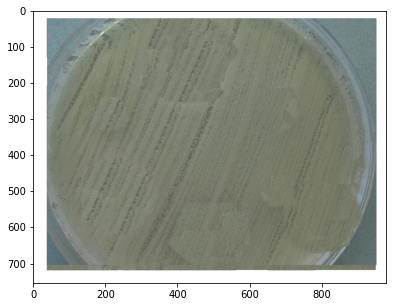

In [ ]:
img_back = back_path.ls()[0]
displaySingleImage(img_back, figsize=(8, 5))

In [ ]:
# Search in foreground dir for images.
fore_path.ls()

[PosixPath('/content/BIODL/data/images/foreground/9_antibiogram_fore_lower_left.png')]

Image size h x w x c (200, 189, 4)


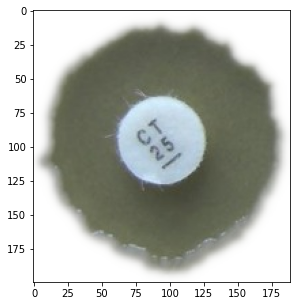

In [ ]:
# Display image 9_antibiogram_fore_lower_left.png.
img_fore_1 = fore_path.ls()[0]
displaySingleImage(img_fore_1, figsize=(5, 5))

### Create Synthetic Image

#### Find Single Coordinate

Next, paste the foreground image at a randomly selected (x, y) position in the background image.  Create serie(s) of coordinates and select randomly a single position(coordinate) from the serie(s).      

1. Find a (x, y) position within the petri dish in the background image 
2. From "1.", create a series of coordinates
3. Choose randomly one coordinate from "2."
4. Paste the foreground image into the background on the choosen coordinate in "3."

In [ ]:
# Note: use the below commands to remove ".ipynb_checkpoints"
# !rm -r /content/data/background/.ipynb_checkpoints
# !rm -r /content/data/foreground/.ipynb_checkpoints

In [ ]:
# You can select any (x, y) position to start creating a serie.  In here, I selected the center of 
#  the background image.
origin_x = 754//2 
origin_y = 980//2

# The size of the serie or the number of elements in the serie.
scale_1 = 300
scale_2 = 500
scale_3 = 150

# Create a serie on x-axis, you can create from y-axis as well.
axis_1 = "x"
axis_2 = "y"

# Positive: to create a serie that starts from the right side of origin_x, origin_y.
#  In the case of when axis = "y", it creates series starting from the lower side of origin_x, origin_y.  
# Negative: to create a serie that starts from the left side of origin_x, origin_y.
#  In the case of when axis = "y", it creates series starting from the upper side of origin_x, origin_y.
side_1 = "positive"
side_2 = "negative"

In [ ]:
# Randomly select a coordinate
# Create 20 coordinates to the right and left hand side of center_x and center_y.
coord_1 = series(axis_1, origin_x, origin_y, scale_1, side_1)
coord_2 = series(axis_2, origin_x, origin_y, scale_3, side_1)
coord_3 = series(axis_1, origin_x, origin_y, scale_1, side_2)
# print(f'sample coordinate 1: {coord_1}')
# print(f'sample coordinate 2: {coord_2}')
# print(f'sample coordinate 3: {coord_3}')


# Add the two coordinates. 
coord = coord_1 + coord_2 + coord_3
# print(f'add sample coordinate 1, 2 and 3: {coord}')

# Randomly select a coordinate.
random.shuffle((coord))

# This is the coordinate in the background image in which the foreground image will be pasted.
coord_paste = coord[0]
print(f'Paste foreground image into {coord_paste}')

Paste foreground image into [287, 490]


#### Paste Single Foreground into Background

Following instructions from [PIL](https://pillow.readthedocs.io/en/5.1.x/reference/Image.html?highlight=composite#PIL.Image.composite), use composite methods to combine the images:

Create composite image by blending images using a transparency mask.<br>

* PIL.Image.composite(image1, image2, mask)

Parameters:	
> image1 – The first image.<br>
image2 – The second image. Must have the same mode and size as the first image.<br>
mask – A mask image. This image can have mode “1”, “L”, or “RGBA”, and must have the same size as the other two images.

In [ ]:
# Open the background image(9_antibiogram_empty_petri.jpg), use data from this image to create another image of the same size.
back_image = back_path.ls()[0]
back = Image.open(back_image)

# Create a new foreground image of the same size as the background image.  The new foreground contains
#  4 channels: R(Red), G(Green), B(Blue), and A(Alpha). 
fore_new = Image.new('RGBA', back.size, color=(0, 0, 0, 0))

# Open "9_antibiogram_fore_lower_left.png". 
fore_1_img = Image.open(img_fore_1)

# Paste "9_antibiogram_fore_lower_left.png" in the newly create fore_new image at the randomly selected coordinate.  
fore_new.paste(fore_1_img, coord_paste)

# Uncomment to visualize how the image looks in Alpha channel. 
#fore_new.getchannel(3)  

In [ ]:
# Create a mask image with the foreground(9_antibiogram_fore_lower_left.png) alpha image.
# Create a new image of the same size as the background image in black color.
mask_image = Image.new('L', back.size, color=0)
fore_1_img_mask = fore_1_img.getchannel(3)
mask_image.paste(fore_1_img_mask, coord_paste)

# Uncomment to visualize how the image looks
#mask_image.getchannel(0)

In [ ]:
# Compositing two images according to mask provided
composite = Image.composite(fore_new, back, mask_image)

# Save the created synthetic image
synthetic_antibiogram_1 = output_path.joinpath('synthetic_antibiogram_1.png')
composite.save(synthetic_antibiogram_1)

Image size h x w x c (754, 980, 3)


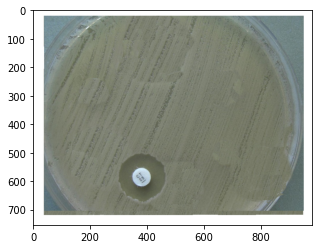

In [ ]:
# Visualize synthetic_antibiogram_1.png.
displaySingleImage(synthetic_antibiogram_1, figsize=(5, 5))

To create a new synthetic image using single foreground, go back to "Create Synthetic Image" and change the values of parameters:
* center_x, center_y
* scale_1 = 10, scale_2
* side_1, side_2
* axis_1, axis_2 
then re-execute all the cells in "Create Synthetic Image".<br>

A second option would be to simply re-execute all the cells from "Randomly select a coordinate" and afterwards. 


#### Bounding Box

In [ ]:
# Grab the alpha pixels above a specified threshold
threshold = 200
mask_arr = np.array(np.greater(np.array(mask_image), threshold), dtype=np.uint8)
hard_mask = Image.fromarray(np.uint8(mask_arr) * 255, 'L') # convert to PIL Image; 'L': (8-bit pixels, black and white)
hardmask_antibiogram_1 = output_path.joinpath('hardmask_antibiogram_1.png')
hard_mask.save(hardmask_antibiogram_1)

# Find the smallest and largest non-zero values in each dimension and calculate the bounding box
nz = np.nonzero(hard_mask)
bbox = [np.min(nz[0]), np.min(nz[1]), np.max(nz[0]), np.max(nz[1])] 
bbox

[504, 296, 679, 467]

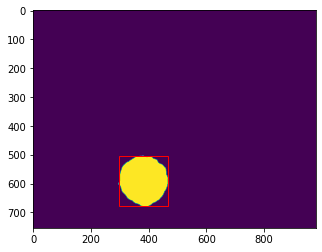

In [ ]:
drawRectangle(hardmask_antibiogram_1, bbox[0], bbox[1], bbox[2], bbox[3])

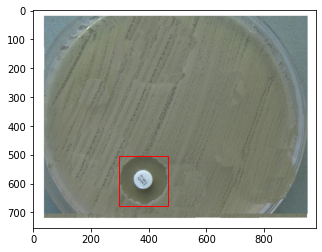

In [ ]:
drawRectangle(synthetic_antibiogram_1, bbox[0], bbox[1], bbox[2], bbox[3])

Reference:
* https://www.immersivelimit.com/tutorials/cutting-out-image-foregrounds-with-gimp
* https://www.immersivelimit.com/tutorials/composing-images-with-python-for-synthetic-datasets
* https://pillow.readthedocs.io/en/5.1.x/reference/Image.html?highlight=composite#PIL.Image.composite
* https://pillow.readthedocs.io/en/5.1.x/reference/Image.html?highlight=paste#PIL.Image.Image.paste
* https://www.youtube.com/watch?v=uhRGix-x5Mg